In [2]:
import numpy as np
import tensorflow as tf
import math
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt 
import os
import cv2
import numpy as np
import random
import scipy.ndimage

In [3]:
# define a function for peak signal to noise ration (PSNR)
psnr_values = []
ssim_values = []
def psnr(target, ref):
    target_data = target.astype(float)
    ref_data = ref.astype(float)
    
    diff = ref_data - target_data
    diff = diff.flatten('C')
    rmse = math.sqrt(np.mean(diff **2.))
    psnr_value = 20 * math.log10(255./rmse)
    psnr_values.append(psnr_value)
    return psnr_value

def mse(target, ref):
    err = np.sum((target.astype('float')- ref.astype('float'))**2)
    err /= float(target.shape[0]*target.shape[1])
    return err

def compare_image(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    ssim_value = ssim(target, ref, win_size=3, channel_axis=-1)
    scores.append(ssim_value) 
    ssim_values.append(ssim_value)
    return scores

In [4]:
import os
import cv2
import numpy as np
import random
import scipy.ndimage

def augment_images(path, output_dir='augmented'):
    os.makedirs(output_dir, exist_ok=True)

    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        if not file.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        image = cv2.imread(file_path)
        if image is None:
            print(f"Skipping {file}, unable to read image.")
            continue
        base_name = os.path.splitext(file)[0]
        augmented_images = {
            f"{base_name}_original.jpg": image,
            f"{base_name}_flip.jpg": flip_image(image),
            f"{base_name}_rotate.jpg": rotate_image(image, angle=30),
            f"{base_name}_bright.jpg": adjust_brightness(image, factor=1.5),
            f"{base_name}_zoom.jpg": zoom_image(image, zoom_factor=1.3),
            f"{base_name}_blur.jpg": apply_gaussian_blur(image), 
            f"{base_name}_shear.jpg": shear_image(image, shear_factor=0.2),  # New
            f"{base_name}_crop.jpg": random_crop(image, crop_size=0.8),  # New
        }

        # Save augmented images
        for aug_file, aug_image in augmented_images.items():
            aug_path = os.path.join(output_dir, aug_file)
            cv2.imwrite(aug_path, aug_image)
            print(f"Saved {aug_path}")

def flip_image(image):
    return cv2.flip(image, 1)

def rotate_image(image, angle=30):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h))

def adjust_brightness(image, factor=1.2):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * factor, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

def adjust_contrast(image, factor=2.0):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l = np.clip(l * factor, 0, 255)
    lab = cv2.merge([l, a, b])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

def add_salt_pepper_noise(image, amount=0.02):
    row, col, ch = image.shape
    out = np.copy(image)
    num_salt = np.ceil(amount * image.size * 0.5)
    num_pepper = np.ceil(amount * image.size * 0.5)

    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape[:2]]
    out[coords[0], coords[1], :] = 255

    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape[:2]]
    out[coords[0], coords[1], :] = 0

    return out

def zoom_image(image, zoom_factor=1.2):
    h, w = image.shape[:2]
    new_h, new_w = int(h / zoom_factor), int(w / zoom_factor)
    top = (h - new_h) // 2
    left = (w - new_w) // 2
    cropped = image[top:top+new_h, left:left+new_w]
    return cv2.resize(cropped, (w, h), interpolation=cv2.INTER_CUBIC)

def apply_gaussian_blur(image, kernel_size=(5, 5)):
    return cv2.GaussianBlur(image, kernel_size, 0)

def elastic_transform(image, alpha, sigma):
    random_state = np.random.RandomState(None)
    shape = image.shape
    dx = scipy.ndimage.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = scipy.ndimage.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
    return cv2.remap(image, indices[1].astype(np.float32), indices[0].astype(np.float32), cv2.INTER_LINEAR)

def shear_image(image, shear_factor=0.2):
    """ Apply shear transformation """
    h, w = image.shape[:2]
    M = np.array([[1, shear_factor, 0], [0, 1, 0]], dtype=np.float32)
    return cv2.warpAffine(image, M, (w, h))

def random_crop(image, crop_size=0.8):
    """ Randomly crops an image and resizes it back """
    h, w = image.shape[:2]
    new_h, new_w = int(h * crop_size), int(w * crop_size)
    top = random.randint(0, h - new_h)
    left = random.randint(0, w - new_w)
    cropped = image[top:top+new_h, left:left+new_w]
    return cv2.resize(cropped, (w, h), interpolation=cv2.INTER_CUBIC)

# Example usage
# augment_images('original')


In [5]:
def prepare_images(path, factor, quality = 5):
    # loop thrught the files in the directory
    for file in os.listdir(path):
        # open the file
        image = cv2.imread(path + '/' + file)
        # find the old and new image dimensions
        h, w, c = image.shape
        new_h, new_w = int(h / factor), int(w /factor)
        # resize the image - down
        image = cv2.resize(image, (new_w, new_h), interpolation= cv2.INTER_CUBIC)
        # resize the image - up
        image = cv2.resize(image, (w, h), interpolation = cv2.INTER_CUBIC)
        # save he image
        output_dir = 'degraded'
        os.makedirs(output_dir, exist_ok=True) 
        output_path = os.path.join(output_dir, file)
        print(f"Saving {output_path} with quality={quality}")
        cv2.imwrite(output_path, image, [cv2.IMWRITE_JPEG_QUALITY, quality])

In [6]:
# prepare_images('augmented', 16, 5)

In [7]:
# testing the generated images using the image quality metrics
count = 0

for file in os.listdir('augmented/'):
    if count > 39:
        break
    count += 1
    degraded = cv2.imread('degraded/{}'.format(file))
    augmented= cv2.imread('augmented/{}'.format(file))
    # calculate the scores
    # scores = compare_image(degraded, augmented)
    # print(f"{file} \nPSNR: {scores[0]}\n MSE : {scores[1]}\nSSIM : {scores[2]}")

In [8]:
print(f"Average PSNR: {np.mean(psnr_values):.2f} dB")
print(f"Average SSIM: {np.mean(ssim_values):.4f}")

Average PSNR: nan dB
Average SSIM: nan


d:\Major Project\Super Resolution\env\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Major Project\Super Resolution\env\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [9]:
# define necessary image processing functions
def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1 : sz[1]]
    return img

In [10]:
def load_images(image_dir, source_dir, img_size=(256, 256)):
    images = []
    labels = []
    
    for file in os.listdir(image_dir):
        target = cv2.imread(os.path.join(image_dir, file))  
        ref = cv2.imread(os.path.join(source_dir, file))
        
        if target is not None and ref is not None:
            target = modcrop(target, 3)
            ref = modcrop(ref, 3)
            
            # Convert to grayscale (Y channel of YCrCb)
            target = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)[:, :, 0]
            ref = cv2.cvtColor(ref, cv2.COLOR_BGR2YCrCb)[:, :, 0]
            
            # Resize images to a fixed shape
            target = cv2.resize(target, img_size, interpolation=cv2.INTER_CUBIC)
            ref = cv2.resize(ref, img_size, interpolation=cv2.INTER_CUBIC)
            
            images.append(target.astype(np.float32) / 255.0)
            labels.append(ref.astype(np.float32) / 255.0)
    
    X = np.array(images)
    Y = np.array(labels)
    return X, Y

In [ ]:
# load dataset
degraded_dir = 'degraded/'  # Directory containing low-resolution images
original_dir = 'augmented/'  # Directory containing high-resolution images
X, Y = load_images(degraded_dir, original_dir)
X = X[..., np.newaxis]  # Add channel dimension
Y = Y[..., np.newaxis]  # Add channel dimension

In [ ]:
X.shape, Y.shape

((4800, 256, 256, 1), (4800, 256, 256, 1))

In [ ]:
# Split dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape, Y_train.shape)


(3840, 256, 256, 1) (3840, 256, 256, 1)


In [ ]:
def pixel_mse_loss(x,y):
    return tf.reduce_mean( (x - y) ** 2 )

In [ ]:
# define the SRCNN model
def model():
    SRCNN = Sequential() 
    SRCNN.add(Input(shape=(None, None, 1))) 
    SRCNN.add(Conv2D(filters = 128, kernel_size=  (9,9), kernel_initializer= 'glorot_uniform', activation = 'relu', padding = 'same', use_bias = True))   
    SRCNN.add(Conv2D(filters = 64, kernel_size = (3,3), kernel_initializer='glorot_uniform', activation = 'relu', padding = 'same', use_bias = True))
    SRCNN.add(Conv2D(filters = 1, kernel_size = (5,5), kernel_initializer='glorot_uniform', activation = 'linear', padding = 'same', use_bias = True)) 
    adam = Adam(learning_rate=0.001) 
    SRCNN.compile(optimizer = adam, loss= 'mean_squared_error', metrics = ['mean_squared_error'])
    return SRCNN

In [ ]:
srcnn = model()
history = srcnn.fit(X_train, Y_train, epochs=10, batch_size=2, validation_data=(X_test, Y_test))

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
srcnn.summary()

Model: "sequential_2"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, None, None, 128)   10496     
                                                                 
 conv2d_7 (Conv2D)           (None, None, None, 64)    73792     
                                                                 
 conv2d_8 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


480/480 [==============================] - 6s 12ms/step - loss: 0.0013 - mean_squared_error: 0.0013


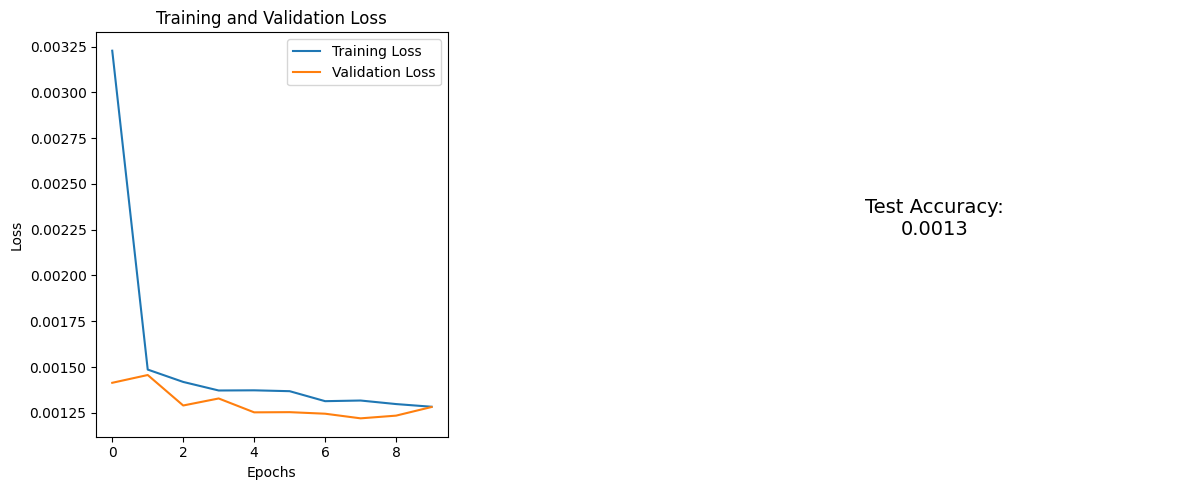

In [ ]:
test_loss, test_accuracy = srcnn.evaluate(X_test, Y_test,batch_size=1)  # Modify if using other metrics

# Plot Loss Graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

if 'accuracy' in history.history:
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training, Validation & Test Accuracy')
    plt.legend()

# Display the final test accuracy as text
plt.subplot(1, 3, 3)
plt.axis('off')
plt.text(0.3, 0.5, f'Test Accuracy:\n{test_accuracy:.4f}', fontsize=14, ha='center')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Function to evaluate model performance
def evaluate_model(model, X_test, Y_test):
    predictions = model.predict(X_test, batch_size=1)

    psnr_values, ssim_values = [], []
    for i in range(len(X_test)):
        pred_img = np.clip(predictions[i], 0, 1)  # Clip values to valid range
        true_img = Y_test[i]

        # Compute PSNR & SSIM
        psnr_value = psnr(true_img, pred_img, data_range=1.0)  # Ensure correct range
        ssim_value = ssim(true_img, pred_img, data_range=1.0, win_size=3, channel_axis=-1)  # Fix applied here
        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)

    # Print average results
    print(f"Average PSNR: {np.mean(psnr_values):.2f} dB")
    print(f"Average SSIM: {np.mean(ssim_values):.4f}")

# Run evaluation
evaluate_model(srcnn, X_test, Y_test)


480/480 [==============================] - 5s 10ms/step
Average PSNR: 29.17 dB
Average SSIM: 0.7745


1/1 [==============================] - 0s 103ms/step


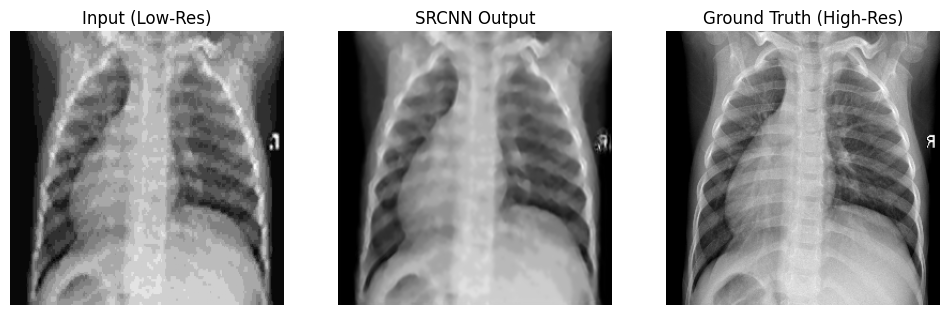

In [ ]:
import cv2

# Visualize a sample image
def visualize_results(model, X_test, Y_test, index=0):
    predicted = model.predict(np.expand_dims(X_test[index], axis=0))[0]

    # Convert BGR to RGB for visualization
    input_image = cv2.cvtColor(X_test[index], cv2.COLOR_BGR2RGB)
    predicted_image = cv2.cvtColor(np.clip(predicted, 0, 1), cv2.COLOR_BGR2RGB)
    ground_truth = cv2.cvtColor(Y_test[index], cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.title("Input (Low-Res)")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_image)
    plt.title("SRCNN Output")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth)
    plt.title("Ground Truth (High-Res)")
    plt.axis('off')

    plt.show()

# Visualize first test sample
visualize_results(srcnn, X_test, Y_test, index=1)


In [ ]:
# Save the trained model weights
srcnn.save_weights('srcnn_trained.weights_new.h5')
print("SRCNN Model trained successfully and weights saved as 'srcnn_trained.weights.h5'")

SRCNN Model trained successfully and weights saved as 'srcnn_trained.weights.h5'
